# IMDB REVIEWS DATASET

In [1]:
path_do_data='/kaggle/input/imdb-dataset/IMDB Dataset (1).csv'

In [2]:
import pandas as pd
import numpy as np
data=pd.read_csv(path_do_data)

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
#Basic Preprocessing of Data
import re
import string
def basic_preprocesisng(text):
  text=text.lower()
  text=re.sub(r'<.*?>','',text) # Remove the html tags from data
  text=re.sub(r'\S+@\S+','',text) # Remove Mails
  text=re.sub(r'\d+','',text) # Remove digits
  return text
data['clean_text']=data['review'].apply(basic_preprocesisng)

In [6]:
data['label']=data['sentiment'].map({'negative':0,'positive':1})

In [7]:
! pip install --quiet nltk

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
stop_words=set(stopwords.words('english'))
stemmer=PorterStemmer()
lemmatizer=WordNetLemmatizer()
def preprocess_pipeline(text):
  tokens=word_tokenize(text)
  tokens=[t for t in tokens if t not in stop_words]
  stemmed=[stemmer.stem(t) for t in tokens]
  lemmatized=[lemmatizer.lemmatize(t) for t in tokens]
  return {'tokens': tokens,'stemmed': stemmed,'lemmatized': lemmatized}
data['processed']=data['clean_text'].apply(preprocess_pipeline)

In [10]:
from collections import defaultdict, Counter
def tokenize(doc):
  doc=doc.lower()
  doc=re.sub(r'[^\w\s]','',doc) #. Remove punctuation
  return doc.split()
corpus=data['clean_text'].tolist()
tokenized_corpus=[tokenize(doc) for doc in corpus]


In [11]:
len(tokenized_corpus)

50000

## TF-IDF

In [12]:
#. Build the Vocabulary
vocab=set()
for tokens in tokenized_corpus:
  vocab.update(tokens)
vocab=sorted(list(vocab))
vocab_index={word: i for i,word in enumerate(vocab)}

# Compute TF
data_counts=defaultdict(int)
for tokens in tokenized_corpus:
  unique_terms=set(tokens)
  for term in unique_terms:
    data_counts[term]+=1


In [13]:
len(data_counts)

215027

In [14]:
N=len(tokenized_corpus)
idf={}
for term in vocab:
  data_t=data_counts.get(term,0)
  idf[term]=np.log(N/(1+data_t)) #added 1 to avoid div by zero


In [15]:
from collections import defaultdict, Counter
from scipy.sparse import lil_matrix
import numpy as np

rows = []
cols = []
ndata = []

for doc_idx, tokens in enumerate(tokenized_corpus):
    term_counts = Counter(tokens)
    total_terms = len(tokens)
    for term, count in term_counts.items():
        if term in vocab_index:
            tf = count / total_terms
            tfidf = tf * idf[term]
            rows.append(doc_idx)
            cols.append(vocab_index[term])
            ndata.append(tfidf)

from scipy.sparse import coo_matrix
tfidf_sparse = coo_matrix((ndata, (rows, cols)), shape=(len(tokenized_corpus), len(vocab)))


In [16]:
data

,review,sentiment,clean_text,label,processed
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,1,"{'tokens': ['one', 'reviewers', 'mentioned', '..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...,1,"{'tokens': ['wonderful', 'little', 'production..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,1,"{'tokens': ['thought', 'wonderful', 'way', 'sp..."
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,0,"{'tokens': ['basically', ''s', 'family', 'litt..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",1,"{'tokens': ['petter', 'mattei', ''s', '``', 'l..."
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,1,"{'tokens': ['thought', 'movie', 'right', 'good..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di...",0,"{'tokens': ['bad', 'plot', ',', 'bad', 'dialog..."
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,0,"{'tokens': ['catholic', 'taught', 'parochial',..."
49998,I'm going to have to disagree with the previou...,negative,i'm going to have to disagree with the previou...,0,"{'tokens': [''m', 'going', 'disagree', 'previo..."


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# tfidf = TfidfVectorizer(max_features=5000)
# X = tfidf.fit_transform(df['processed'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(tfidf_sparse, y, test_size=0.2, random_state=42)
model=LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# BOW - BAG OF WORDS

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer=WordNetLemmatizer()
stop_words=set(stopwords.words('english'))
def preprocess_pipeline_bow(text):
  text=text.lower()
  text=re.sub(r'[^\w\s]','',text)
  tokens=word_tokenize(text)
  tokens=[lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
  return tokens
tokenized_corpus_bow=data['review'].apply(preprocess_pipeline_bow)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
tokenized_corpus_bow

0        [one, reviewer, mentioned, watching, 1, oz, ep...
1        [wonderful, little, production, br, br, filmin...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, there, family, little, boy, jake, ...
4        [petter, matteis, love, time, money, visually,...
                               ...                        
49995    [thought, movie, right, good, job, wasnt, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [im, going, disagree, previous, comment, side,...
49999    [one, expects, star, trek, movie, high, art, f...
Name: review, Length: 50000, dtype: object

# BUILD VOCABULARY

In [20]:
from collections import Counter
all_tokens_bow=[token for doc in tokenized_corpus_bow for token in doc]
vocab_counter_bow=Counter(all_tokens_bow)
vocab_bow=sorted(vocab_counter_bow,key=vocab_counter_bow.get,reverse=True)[:5000]
vocab_index_bow={word: i for i,word in enumerate(vocab_bow)}


# CREATE BOW VECTORS

In [21]:
from scipy.sparse import lil_matrix
rows,cols,data_bow=[],[],[]
for doc_idx,tokens in enumerate(tokenized_corpus_bow):
  word_counts=Counter(tokens)
  for word,count in word_counts.items():
    if word in vocab_index_bow:
      rows.append(doc_idx)
      cols.append(vocab_index_bow[word])
      data_bow.append(count)
bow_sparse=coo_matrix((data_bow,(rows,cols)),shape=(len(tokenized_corpus_bow),len(vocab_bow)))

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(bow_sparse, data['label'], test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4961
           1       0.87      0.88      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# WORD2VEC CBOW

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import numpy as np
import random
import re
from nltk.tokenize import word_tokenize

def preprocess_imdb_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return word_tokenize(text)

# Apply to all reviews (assuming df["review"] holds your reviews)
tokenized_reviews_cbow = data['review'].apply(preprocess_imdb_text).tolist()

In [24]:
from collections import Counter
tokens_cbow=[word for review in tokenized_reviews_cbow for word in review]
vocab_counter=Counter(tokens_cbow)
vocab_size_limit=10000
most_common_words=vocab_counter.most_common(vocab_size_limit)
vocab_cbow=[word for word,_ in most_common_words]
word2idx={word:idx for idx,word in enumerate(vocab)}
idx2word={idx:word for word,idx in word2idx.items()}


# CBOW TRAINING PAIRS

In [25]:
def generate_cbow_pairs(tokenized_reviews,word2idx, window_size=2):
  data=[]
  for tokens in tokenized_reviews:
    tokens = [t for t in tokens if t in word2idx]
    for i in range(window_size,len(tokens)-window_size):
      context=(tokens[i-window_size:i]+tokens[i+1:i+window_size+1])
      target=tokens[i]
      data.append((context,target))
  return data
cbow_data=generate_cbow_pairs(tokenized_reviews_cbow,word2idx)
print(f"sample:{cbow_data[0]}")
print(f"total pairs:{len(cbow_data)}")

sample:(['one', 'of', 'other', 'reviewers'], 'the')
total pairs:11155972


In [26]:
for i in range(10):
  print(cbow_data[i])

(['one', 'of', 'other', 'reviewers'], 'the')
(['of', 'the', 'reviewers', 'has'], 'other')
(['the', 'other', 'has', 'mentioned'], 'reviewers')
(['other', 'reviewers', 'mentioned', 'that'], 'has')
(['reviewers', 'has', 'that', 'after'], 'mentioned')
(['has', 'mentioned', 'after', 'watching'], 'that')
(['mentioned', 'that', 'watching', 'just'], 'after')
(['that', 'after', 'just', 'oz'], 'watching')
(['after', 'watching', 'oz', 'episode'], 'just')
(['watching', 'just', 'episode', 'youll'], 'oz')


# CBOW MODEL

In [27]:
import random
random.shuffle(cbow_data)
cbow_data = cbow_data[:5000000]

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# 🔌 Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  CBOW Model Definition
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, context_idxs):
        embeds = self.embeddings(context_idxs)     # (batch, context_size, embed_dim)
        mean_embed = embeds.mean(dim=1)            # (batch, embed_dim)
        out = self.linear(mean_embed)              # (batch, vocab_size)
        return out

#  Prepare Batches
def prepare_batch(data, batch_size):
    random.shuffle(data)
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        clean_batch = [(ctx, tgt) for ctx, tgt in batch if all(w in word2idx for w in ctx) and tgt in word2idx]
        if not clean_batch:
            continue
        context_batch = [torch.tensor([word2idx[w] for w in ctx], dtype=torch.long) for ctx, tgt in clean_batch]
        target_batch = [word2idx[tgt] for ctx, tgt in clean_batch]
        yield torch.stack(context_batch).to(device), torch.tensor(target_batch).to(device)

#  Initialize Model
embedding_dim = 100
model_cbow = CBOW(len(vocab), embedding_dim).to(device)  # 🛑 Move model to GPU
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cbow.parameters(), lr=0.01)

#  Training Loop
epochs = 5
for epoch in range(epochs):
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{epochs}")
    for i, (context_batch, target_batch) in enumerate(prepare_batch(cbow_data, batch_size=1024)):
        optimizer.zero_grad()
        output = model_cbow(context_batch)  # already on GPU
        loss = loss_fn(output, target_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} completed. Total Loss: {total_loss:.4f}")


Using device: cuda

Epoch 1/5
Epoch 1 completed. Total Loss: 30343.7346

Epoch 2/5
Epoch 2 completed. Total Loss: 26726.3534

Epoch 3/5
Epoch 3 completed. Total Loss: 25141.2548

Epoch 4/5
Epoch 4 completed. Total Loss: 24204.5797

Epoch 5/5
Epoch 5 completed. Total Loss: 23669.5348


In [29]:
word_embeddings = model_cbow.embeddings.weight.data.cpu().numpy()


In [30]:
import numpy as np

# Pick top 200 frequent words that are in your vocab
top_words = list(word2idx.keys())[10000:10100]
top_idxs = [word2idx[word] for word in top_words]
selected_embeddings = word_embeddings[top_idxs]


In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings = tsne.fit_transform(selected_embeddings)

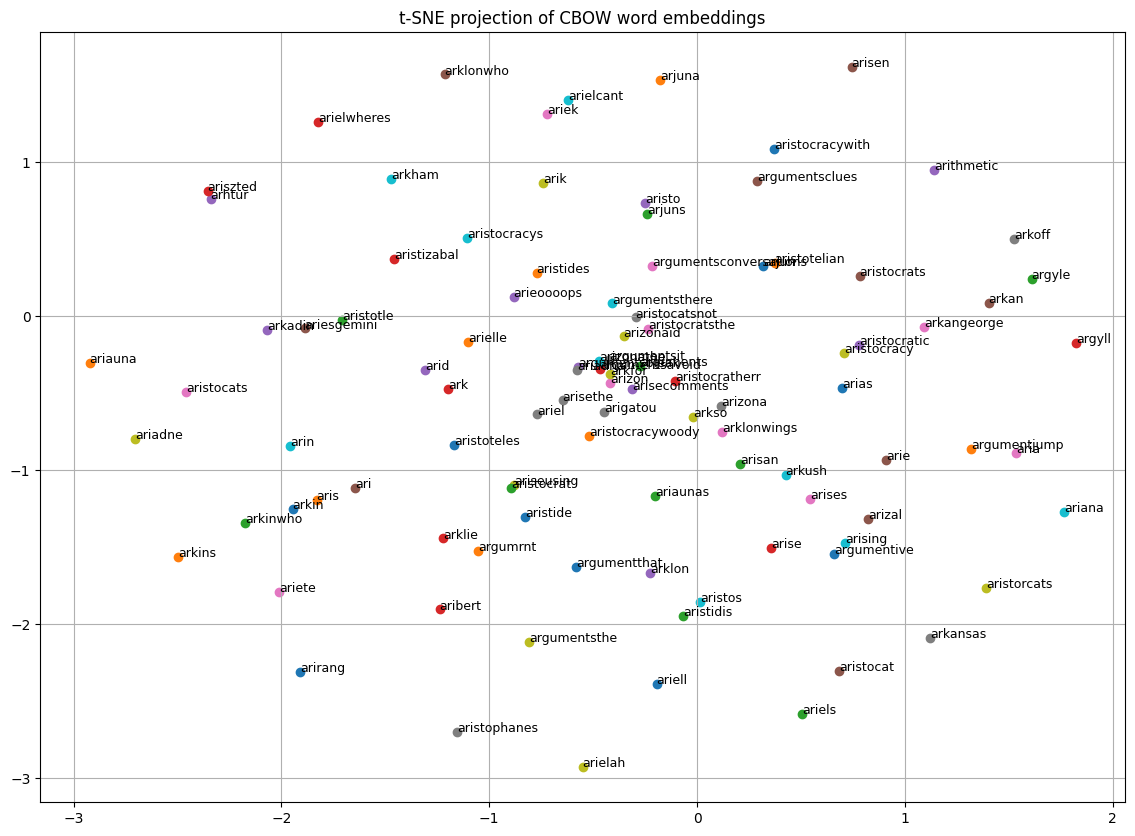

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
for i, label in enumerate(top_words):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, (x, y), fontsize=9)
plt.title("t-SNE projection of CBOW word embeddings")
plt.grid(True)
plt.show()


In [33]:
!pip install -q gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 45.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [34]:
from gensim.downloader import load
glove_model = load("glove-wiki-gigaword-100") 

[======--------------------------------------------] 12.2% 15.6/128.1MB downloaded

In [35]:
words_to_compare = ['good', 'bad', 'movie', 'film', 'terrible', 'great', 'boring', 'funny', 'love', 'hate','amazing','worst','brilliant']
words = [w for w in words_to_compare if w in word2idx and w in glove_model]

In [36]:
words

['good',
 'bad',
 'movie',
 'film',
 'terrible',
 'great',
 'boring',
 'funny',
 'love',
 'hate',
 'amazing',
 'worst',
 'brilliant']

In [37]:
import numpy as np
glove_vectors = np.array([glove_model[w] for w in words])
cbow_vectors = np.array([model_cbow.embeddings.weight[word2idx[w]].detach().cpu().numpy() for w in words])


In [38]:
from sklearn.manifold import TSNE

combined = np.vstack([cbow_vectors, glove_vectors])
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced = tsne.fit_transform(combined)

cbow_2d = reduced[:len(words)]
glove_2d = reduced[len(words):]


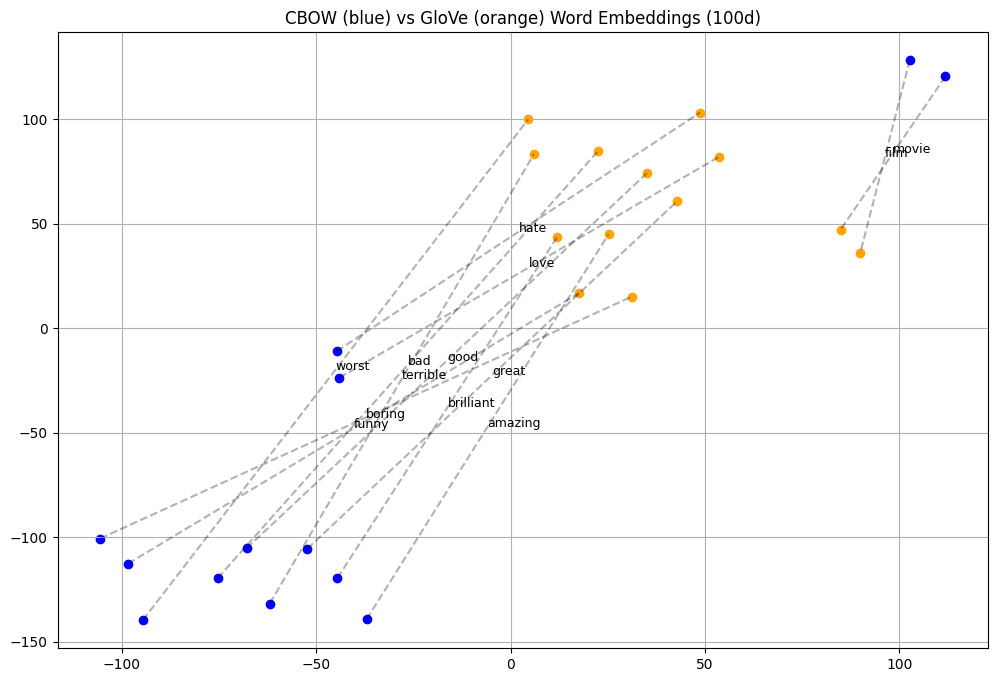

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    x1, y1 = cbow_2d[i]
    x2, y2 = glove_2d[i]
    plt.scatter(x1, y1, color='blue')
    plt.scatter(x2, y2, color='orange')
    plt.plot([x1, x2], [y1, y2], 'k--', alpha=0.3)
    plt.annotate(word, ((x1 + x2)/2, (y1 + y2)/2), fontsize=9)

plt.title("CBOW (blue) vs GloVe (orange) Word Embeddings (100d)")
plt.grid(True)
plt.show()


# SKIP-GRAM

In [40]:
def generate_skipgram_pairs(tokenized_reviews, word2idx, window_size=2):
    data = []
    for tokens in tokenized_reviews:
        tokens = [t for t in tokens if t in word2idx]
        for i in range(len(tokens)):
            center = tokens[i]
            for j in range(-window_size, window_size + 1):
                if j != 0 and 0 <= i + j < len(tokens):
                    context = tokens[i + j]
                    data.append((center, context))
    return data

skipgram_data = generate_skipgram_pairs(tokenized_reviews_cbow, word2idx, window_size=2)
print(f"Sample: {skipgram_data[0]}")
print(f"Total pairs: {len(skipgram_data)}")


Sample: ('one', 'of')
Total pairs: 45123888


In [41]:
skipgram_data[0:20]

[('one', 'of'),
 ('one', 'the'),
 ('of', 'one'),
 ('of', 'the'),
 ('of', 'other'),
 ('the', 'one'),
 ('the', 'of'),
 ('the', 'other'),
 ('the', 'reviewers'),
 ('other', 'of'),
 ('other', 'the'),
 ('other', 'reviewers'),
 ('other', 'has'),
 ('reviewers', 'the'),
 ('reviewers', 'other'),
 ('reviewers', 'has'),
 ('reviewers', 'mentioned'),
 ('has', 'other'),
 ('has', 'reviewers'),
 ('has', 'mentioned')]

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np

# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# 2. Skip-Gram Data Generation
def generate_skipgram_pairs(tokenized_reviews, word2idx, window_size=2, max_pairs=None):
    data = []
    for tokens in tokenized_reviews:
        tokens = [t for t in tokens if t in word2idx]
        for i in range(len(tokens)):
            center = tokens[i]
            for j in range(-window_size, window_size + 1):
                if j == 0 or not (0 <= i + j < len(tokens)):
                    continue
                context = tokens[i + j]
                data.append((center, context))
                if max_pairs and len(data) >= max_pairs:
                    return data
    return data

# 3. Define Model
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, center_word_idx):
        embed = self.embeddings(center_word_idx)  # (batch, embed_dim)
        out = self.linear(embed)                  # (batch, vocab_size)
        return out

# 4. Batch Preparation
def prepare_batch_skipgram(data, batch_size):
    random.shuffle(data)
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        clean_batch = [(c, t) for c, t in batch if c in word2idx and t in word2idx]
        if not clean_batch:
            continue
        center_batch = torch.tensor([word2idx[c] for c, t in clean_batch], dtype=torch.long).to(device)
        target_batch = torch.tensor([word2idx[t] for c, t in clean_batch], dtype=torch.long).to(device)
        yield center_batch, target_batch

# 5. Training
embedding_dim = 100
model_skipgram = SkipGram(len(vocab), embedding_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_skipgram.parameters(), lr=0.01)

# Limit training size for faster debug
skipgram_data = generate_skipgram_pairs(tokenized_reviews_cbow, word2idx, window_size=2, max_pairs=500000)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{epochs}")
    for i, (center_batch, target_batch) in enumerate(prepare_batch_skipgram(skipgram_data, batch_size=1024)):
        optimizer.zero_grad()
        output = model_skipgram(center_batch)         # (batch, vocab_size)
        loss = loss_fn(output, target_batch) # cross-entropy expects (batch, vocab_size) and (batch,)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if i % 100 == 0:
            print(f"  Batch {i}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} completed. Total Loss: {total_loss:.4f}")


Using: cuda

Epoch 1/5
  Batch 0, Loss: 12.4556
  Batch 100, Loss: 7.8090
  Batch 200, Loss: 7.3080
  Batch 300, Loss: 7.1500
  Batch 400, Loss: 7.1332
Epoch 1 completed. Total Loss: 3764.0726

Epoch 2/5
  Batch 0, Loss: 6.2206
  Batch 100, Loss: 6.3602
  Batch 200, Loss: 6.5655
  Batch 300, Loss: 6.6798
  Batch 400, Loss: 6.6359
Epoch 2 completed. Total Loss: 3216.7635

Epoch 3/5
  Batch 0, Loss: 6.0290
  Batch 100, Loss: 6.1848
  Batch 200, Loss: 6.4199
  Batch 300, Loss: 6.3580
  Batch 400, Loss: 6.3725
Epoch 3 completed. Total Loss: 3109.1124

Epoch 4/5
  Batch 0, Loss: 5.8041
  Batch 100, Loss: 6.1642
  Batch 200, Loss: 6.2293
  Batch 300, Loss: 6.1986
  Batch 400, Loss: 6.2580
Epoch 4 completed. Total Loss: 3028.7251

Epoch 5/5
  Batch 0, Loss: 5.7979
  Batch 100, Loss: 5.9533
  Batch 200, Loss: 6.0967
  Batch 300, Loss: 6.1622
  Batch 400, Loss: 6.1607
Epoch 5 completed. Total Loss: 2965.5690


In [44]:
words_to_compare = ['good', 'bad', 'movie', 'film', 'terrible', 'great', 'boring', 'funny', 'love', 'hate']
words = [w for w in words_to_compare if w in word2idx]
cbow_vectors = np.array([model_cbow.embeddings.weight[word2idx[w]].detach().cpu().numpy() for w in words])
skipgram_vectors = np.array([model_skipgram.embeddings.weight[word2idx[w]].detach().cpu().numpy() for w in words])


# CBOW VS SKIPGRAM

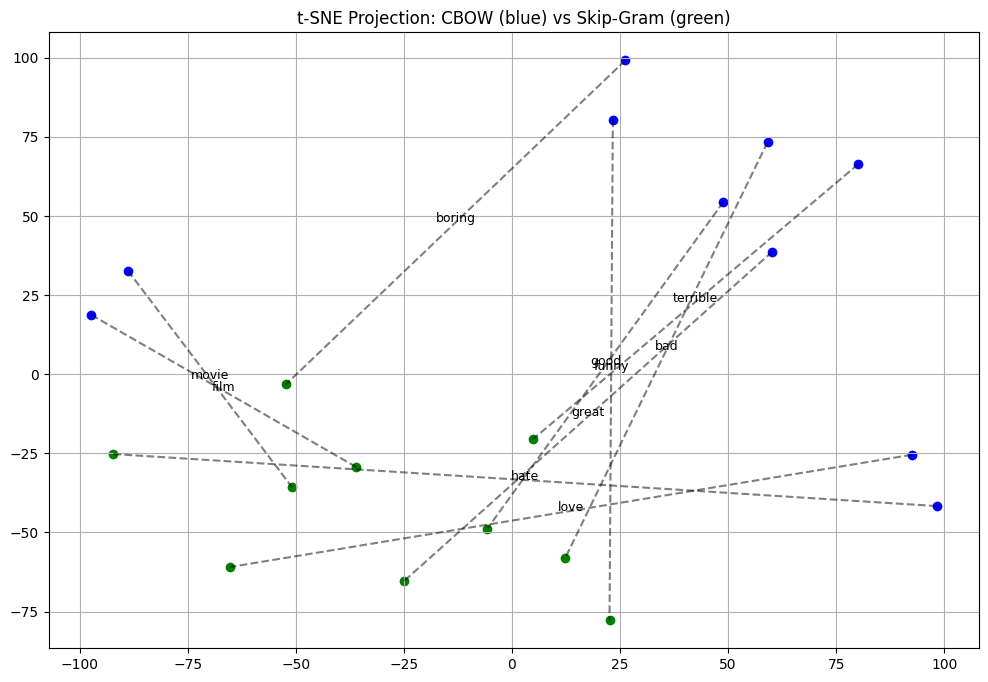

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Stack vectors and apply t-SNE
combined_vectors = np.vstack([cbow_vectors, skipgram_vectors])
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced = tsne.fit_transform(combined_vectors)

# Split the reduced vectors back
cbow_2d = reduced[:len(words)]
skipgram_2d = reduced[len(words):]

# Plotting
plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    x_cbow, y_cbow = cbow_2d[i]
    x_skip, y_skip = skipgram_2d[i]

    # CBOW: blue dot
    plt.scatter(x_cbow, y_cbow, color='blue')
    # SkipGram: green dot
    plt.scatter(x_skip, y_skip, color='green')
    # Dashed line connecting both
    plt.plot([x_cbow, x_skip], [y_cbow, y_skip], 'k--', alpha=0.5)

    # Word label
    plt.annotate(word, ((x_cbow + x_skip) / 2, (y_cbow + y_skip) / 2), fontsize=9, ha='center')

plt.title("t-SNE Projection: CBOW (blue) vs Skip-Gram (green)")
plt.grid(True)
plt.show()
